## Vehicle Detection Project
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---
## Histogram of Oriented Gradients (HOG) feature extraction 

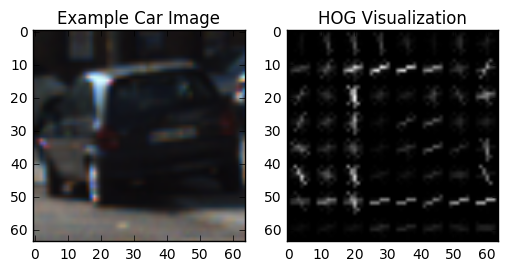

In [157]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
%matplotlib inline

# Read in our vehicles and non-vehicles
cars = glob.glob("data/vehicles/*/*.png")
notcars = glob.glob("data/non-vehicles/*/*.png")

        
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, transform_sqrt=True,feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block),  visualise=False, transform_sqrt=True,feature_vector=feature_vec)
        return features

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

plt.savefig('examples/hog_visualization_features.png')

## Extract binded color features.

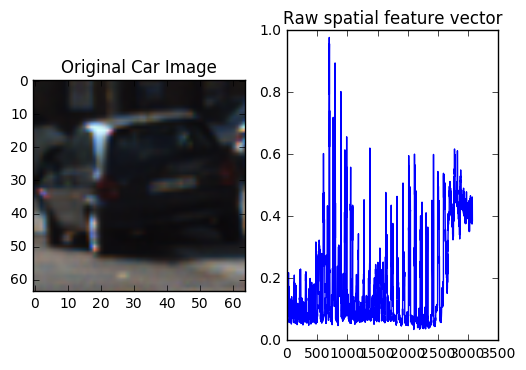

In [158]:
# Define a function to compute binned color features  
def bin_spatial(img, color_space = 'RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

# Define color features
color_space = 'RGB'
spatial_size=(32, 32)

# Apply bin_spatial() to get spatial color features
spatial_features = bin_spatial(image, color_space, spatial_size)

# Create an array stack of spatial feature vectors
X = np.vstack((spatial_features)).astype(np.float64)  

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Original Car Image')
plt.subplot(122)
plt.plot(X)
plt.title('Raw spatial feature vector')

plt.savefig('examples/raw_spatial_features.png')

## Colored histogram features

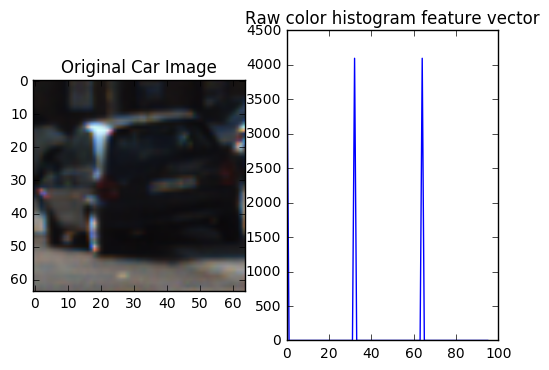

In [159]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define color histogram features
hist_bins=32 
hist_range=(0, 256)

# Apply color_hist() to get color histogram features
hist_features = color_hist(image,hist_bins,hist_range)

# Create an array stack of spatial feature vectors
X = np.vstack((hist_features)).astype(np.float64)  

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Original Car Image')
plt.subplot(122)
plt.plot(X)
plt.title('Raw color histogram feature vector')

plt.savefig('examples/raw_color_histogram_features.png')


## Search and classify - Utility functions

In [160]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image,color_space=color_space, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def convert_color(img, color_space):
    # Will throw error if an invalid conversion is requested
    color_conversion = getattr(cv2, "COLOR_RGB2" + color_space)
    return cv2.cvtColor(img, color_conversion)

## Train a classifier

In [185]:
import glob
import cv2
import numpy as np
import time
import pickle
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle


sample_size = 6000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TRAINING PARAMETERS ###
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell 
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

print("Extract car features...")
# Get features for each set, then stack them together
# Extract color, HOG features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print("Extract not-car features...")
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
# Create an array stack of all feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

print('Final size of car features: ', len(car_features))
print('Final size of not car features: ', len(notcar_features))

print("Normalize features...")
# Normalize features
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Label data
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print("Split dataset into train and test...")
# Split into training & test
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print("Start Training....")

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
clf = LinearSVC()

# Train classifier
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

# Save classifier
clf_file = "svc_pickle.p"
print("Saving classifier, scaler and parameters into file: ", clf_file)

dist_pickle = {}
dist_pickle["svc"]= clf
dist_pickle["color_space"]= color_space
dist_pickle["scaler"]= X_scaler
dist_pickle["orient"]= orient
dist_pickle["pix_per_cell"]= pix_per_cell
dist_pickle["cell_per_block"]=cell_per_block
dist_pickle["spatial_size"]=spatial_size
dist_pickle["hist_bins"]= hist_bins
dist_pickle["hog_channel"]= hog_channel
dist_pickle["spatial_feat"]= spatial_feat
dist_pickle["hist_feat"]= hist_feat
dist_pickle["hog_feat"]= hog_feat


pickle.dump(dist_pickle,  open(clf_file, 'wb'))

Extract car features...
Extract not-car features...
Final size of car features:  6000
Final size of not car features:  6000
Normalize features...
Split dataset into train and test...
Start Training....
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
5.12 Seconds to train SVC...
Test Accuracy of SVC =  0.9929
Saving classifier, scaler and parameters into file:  svc_pickle.p


## Hog Sub-sampling Window Search

In [203]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import math
from scipy.ndimage.measurements import label

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if color_space != 'RGB':
        ctrans_tosearch = convert_color(img_tosearch, color_space)
    else: 
        ctrans_tosearch = np.copy(img_tosearch) 
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    cells_per_step = 2  # Instead of overlap, define how many cells to step

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    nxsteps = math.ceil((nxblocks - nblocks_per_window) // cells_per_step)
    nysteps = math.ceil((nyblocks - nblocks_per_window) // cells_per_step)
    
    # Define blocks and steps as above
    #nxblocks = (ch1.shape[1] // pix_per_cell)-1
    #nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    #nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    #window = 64 + 8
    #nblocks_per_window = (window // pix_per_cell)-1 
    #cells_per_step = 2  # Instead of overlap, define how many cells to step
    #nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    #nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, color_space=color_space,size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = [(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)]
                box_list.append(box)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return box_list, draw_img

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



## Pipeline (Images)

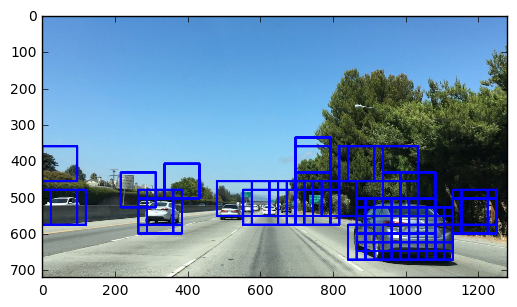

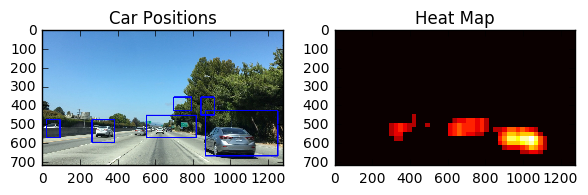

In [204]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
color_space = dist_pickle["color_space"] 
ystart = 336
ystop = 700
scale = 1.5

def pipeline(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space):
    box_list, hog_sub_sampled_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    #print(labels[1], 'cars found')
    #plt.imshow(labels[0])
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return hog_sub_sampled_img, draw_img 

img = mpimg.imread('test_images/bbox-example-image.jpg')
hog_sub_sampled_img, draw_img = pipeline(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space)
plt.imshow(hog_sub_sampled_img)
plt.savefig('examples/hog_subsampling_windows_search.jpg')
fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.savefig('examples/heatmap_based_multiple_detections_and_false_positives.jpg')

## Process Input Images

test_images/bbox-example-image.jpg
0.51 Seconds to find_cars...
test_images/test1.jpg
0.48 Seconds to find_cars...
test_images/test2.jpg
0.49 Seconds to find_cars...
test_images/test3.jpg
0.5 Seconds to find_cars...
test_images/test4.jpg
0.46 Seconds to find_cars...
test_images/test5.jpg
0.48 Seconds to find_cars...
test_images/test6.jpg
0.47 Seconds to find_cars...


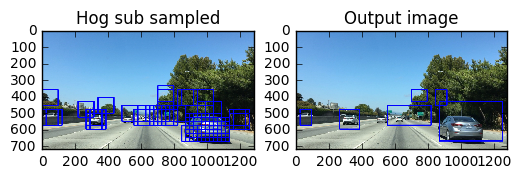

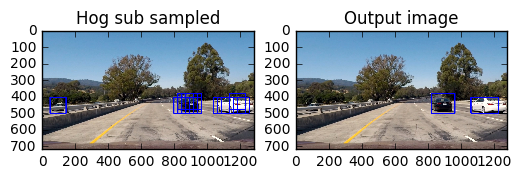

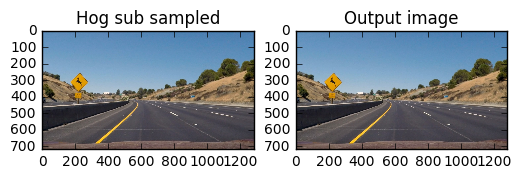

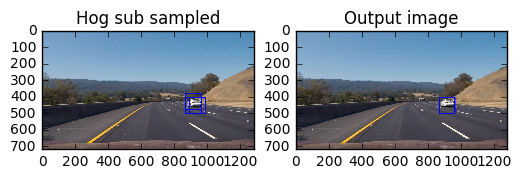

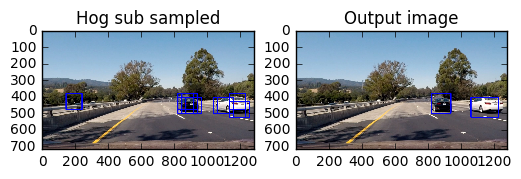

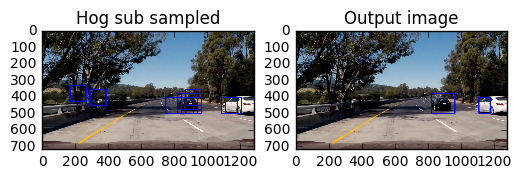

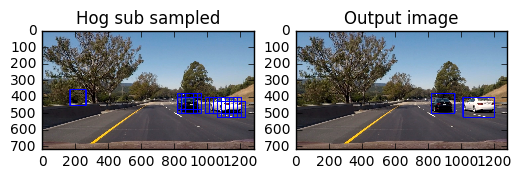

In [205]:
import os
import pickle
import time
import cv2
import matplotlib.image as mpimg
import glob
from matplotlib import pyplot as plt


# Load classifier and parameters
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
color_space = dist_pickle["color_space"] # Color space in which to process the image(input is RGB)
X_scaler = dist_pickle["scaler"] # Scaler used to normalize features
spatial_size = dist_pickle["spatial_size"] # Size of spatial features
hist_bins = dist_pickle["hist_bins"] # Number of bins to take in color histogram
# HOG Options
orient = dist_pickle["orient"] # Orientation bins
pix_per_cell = dist_pickle["pix_per_cell"] # Pixels per cell
cell_per_block = dist_pickle["cell_per_block"] # Cells per block
hog_channel = dist_pickle["hog_channel"] # Number of channel to take HOG(or 'ALL')
spatial_feat = dist_pickle["spatial_feat"] # Spatial features on or off
hist_feat = dist_pickle["hist_feat"] # Histogram features on or off
hog_feat = dist_pickle["hog_feat"] # HOG features on or off

for filename in glob.glob("test_images/*.jpg"):
    print(filename)
    img = mpimg.imread(filename)
    t=time.time()
    hog_sub_sampled_img, out_img = pipeline(img, ystart, ystop, scale, svc, 
                            X_scaler, orient, pix_per_cell, cell_per_block, 
                            spatial_size, hist_bins,color_space)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to find_cars...')
    plt.figure()
    plt.subplot(121)
    plt.imshow(hog_sub_sampled_img)
    plt.title('Hog sub sampled')
    plt.subplot(122)
    plt.imshow(out_img)
    plt.title('Output image')
    fig.tight_layout()
    orig_filename, _ = os.path.splitext(filename)
    orig_filename = orig_filename.replace('test_images/', '')
    plt.savefig('output_images/' + orig_filename + '.png')

## Process Video

In [206]:
from moviepy.editor import VideoFileClip
import pickle

# Load classifier and parameters
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
color_space = dist_pickle["color_space"] # Color space in which to process the image(input is RGB)
X_scaler = dist_pickle["scaler"] # Scaler used to normalize features
spatial_size = dist_pickle["spatial_size"] # Size of spatial features
hist_bins = dist_pickle["hist_bins"] # Number of bins to take in color histogram
# HOG Options
orient = dist_pickle["orient"] # Orientation bins
pix_per_cell = dist_pickle["pix_per_cell"] # Pixels per cell
cell_per_block = dist_pickle["cell_per_block"] # Cells per block
hog_channel = dist_pickle["hog_channel"] # Number of channel to take HOG(or 'ALL')
spatial_feat = dist_pickle["spatial_feat"] # Spatial features on or off
hist_feat = dist_pickle["hist_feat"] # Histogram features on or off
hog_feat = dist_pickle["hog_feat"] # HOG features on or off

def process_image(image):
    hog_sub_sampled_img, out_img = pipeline(image, ystart, ystop, scale, svc, 
                            X_scaler, orient, pix_per_cell, cell_per_block, 
                            spatial_size, hist_bins,color_space)
    return out_img

output_video = "solution_video.mp4"
clip1 = VideoFileClip("project_video.mp4")
output_clip= clip1.fl_image(process_image)
output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video solution_video.mp4
[MoviePy] Writing video solution_video.mp4


100%|█████████▉| 1260/1261 [10:17<00:00,  2.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solution_video.mp4 

